In [125]:
import torch
import numpy as np
from torch import Tensor
from numpy import ndarray as array
from helper import to_2d, tensor_size

from typing import Callable, Dict, Tuple, List, NamedTuple

In [126]:
TEST_ALL = False

# Boston data

In [127]:
from sklearn.datasets import load_boston

In [128]:
boston = load_boston()

In [129]:
data = boston.data
target = boston.target
features = boston.feature_names

## SciKit Learn Linear Regression

### Data prep

In [130]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

In [132]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [133]:
import matplotlib.pyplot as plt

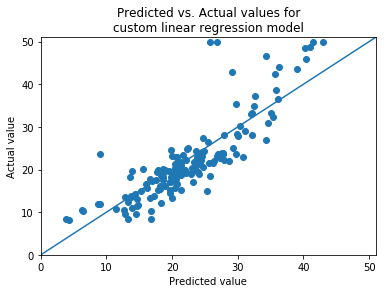

In [134]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/00_linear_real_pred_vs_actual.png");

### Testing changing feature

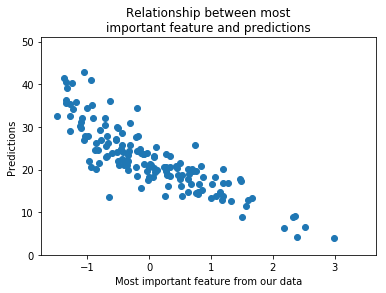

In [147]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([0, 51])
plt.xlabel("Most important feature from our data")
plt.ylabel("Predictions")
plt.title("Relationship between most\nimportant feature and predictions")
plt.savefig("images/03_most_important_feature_vs_predictions.png")

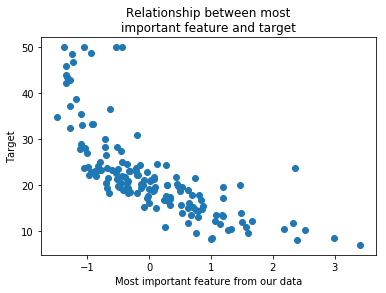

In [148]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target")
plt.savefig("images/02_most_important_feature_vs_target.png")

Non linear relationship

### Model error

In [137]:
np.round(np.mean(np.abs(preds - y_test)), 4)

3.5666

In [138]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

25.4847

In [108]:
import numpy as np
np.round(lr.coef_, 2)

array([-1.01,  0.71,  0.28,  0.71, -2.21,  2.37,  0.72, -2.66,  2.63,
       -1.82, -2.33,  0.86, -4.2 ])

### Manual linear regression

In [109]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [110]:
def permute_data(X, y):
    perm = torch.randperm(X.shape[0])
    return X[perm], y[perm]

In [111]:
def loss_gradients(forward_info: Dict[str, Tensor], 
                   weights: Dict[str, Tensor]) -> Dict[str, Tensor]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdN = torch.ones_like(forward_info['N'])

    dPdB = torch.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = torch.mm(dNdW, dLdN)
    
    dLdB = dLdP * dPdB
    
    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = torch.sum(dLdB)
    
    return loss_gradients

In [112]:
from typing import Iterator
Batch = Tuple[Tensor, Tensor]

def generate_batch(X: Tensor, 
                   y: Tensor,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    
    assert (X.dim() == 2) and (y.dim() == 2), \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [113]:
def forward_loss(X: Tensor,
                 y: Tensor,
                 weights: Dict[str, Tensor]) -> Tuple[Dict[str, Tensor], float]:

    N = torch.mm(X, weights['W'])

    P = torch.add(N, weights['B'].item())

    loss = torch.sum(torch.pow(y - P, 2)).item()

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [114]:
def init_weights_lr(n_in) -> Dict[str, Tensor]:
    
    weights: Dict[str, Tensor] = {}
    W = torch.empty(n_in, 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [115]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y = to_2d(y, "col")
    start = 0

    # Initialize weights
    weights = init_weights_lr(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [116]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

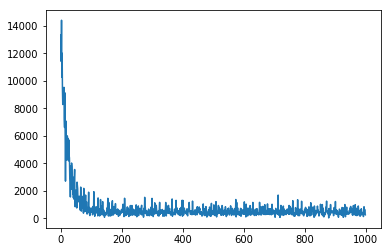

In [117]:
plt.plot(list(range(1000)), losses)

In [155]:
def predict(X: Tensor, 
            weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])

    return torch.add(N, weights['B'].item())

In [162]:
a = np.zeros((100, 12))
b = np.linspace(-2, 2, 100).reshape(100, 1)
test_feature = Tensor(np.concatenate([a, b], axis=1))
preds = predict(test_feature, weights)[:, 0]

In [165]:
test_feature[:, -1]

tensor([-2.0000, -1.9596, -1.9192, -1.8788, -1.8384, -1.7980, -1.7576, -1.7172,
        -1.6768, -1.6364, -1.5960, -1.5556, -1.5152, -1.4747, -1.4343, -1.3939,
        -1.3535, -1.3131, -1.2727, -1.2323, -1.1919, -1.1515, -1.1111, -1.0707,
        -1.0303, -0.9899, -0.9495, -0.9091, -0.8687, -0.8283, -0.7879, -0.7475,
        -0.7071, -0.6667, -0.6263, -0.5859, -0.5455, -0.5051, -0.4646, -0.4242,
        -0.3838, -0.3434, -0.3030, -0.2626, -0.2222, -0.1818, -0.1414, -0.1010,
        -0.0606, -0.0202,  0.0202,  0.0606,  0.1010,  0.1414,  0.1818,  0.2222,
         0.2626,  0.3030,  0.3434,  0.3838,  0.4242,  0.4646,  0.5051,  0.5455,
         0.5859,  0.6263,  0.6667,  0.7071,  0.7475,  0.7879,  0.8283,  0.8687,
         0.9091,  0.9495,  0.9899,  1.0303,  1.0707,  1.1111,  1.1515,  1.1919,
         1.2323,  1.2727,  1.3131,  1.3535,  1.3939,  1.4343,  1.4747,  1.5152,
         1.5556,  1.5960,  1.6364,  1.6768,  1.7172,  1.7576,  1.7980,  1.8384,
         1.8788,  1.9192,  1.9596,  2.00

In [166]:
preds

tensor([30.8802, 30.7129, 30.5455, 30.3782, 30.2109, 30.0435, 29.8762, 29.7089,
        29.5415, 29.3742, 29.2069, 29.0395, 28.8722, 28.7049, 28.5375, 28.3702,
        28.2029, 28.0355, 27.8682, 27.7009, 27.5335, 27.3662, 27.1989, 27.0315,
        26.8642, 26.6969, 26.5295, 26.3622, 26.1949, 26.0275, 25.8602, 25.6928,
        25.5255, 25.3582, 25.1908, 25.0235, 24.8562, 24.6888, 24.5215, 24.3542,
        24.1868, 24.0195, 23.8522, 23.6848, 23.5175, 23.3502, 23.1828, 23.0155,
        22.8482, 22.6808, 22.5135, 22.3462, 22.1788, 22.0115, 21.8442, 21.6768,
        21.5095, 21.3422, 21.1748, 21.0075, 20.8402, 20.6728, 20.5055, 20.3382,
        20.1708, 20.0035, 19.8362, 19.6688, 19.5015, 19.3342, 19.1668, 18.9995,
        18.8321, 18.6648, 18.4975, 18.3301, 18.1628, 17.9955, 17.8281, 17.6608,
        17.4935, 17.3261, 17.1588, 16.9915, 16.8241, 16.6568, 16.4895, 16.3221,
        16.1548, 15.9875, 15.8201, 15.6528, 15.4855, 15.3181, 15.1508, 14.9835,
        14.8161, 14.6488, 14.4815, 14.31

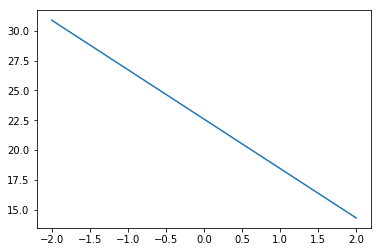

In [167]:
plt.plot(np.array(test_feature[:, -1]), np.array(preds))

In [120]:
from sklearn.metrics import r2_score
r2_score(preds, y_test)

0.5933895451696856

In [ ]:
def predict(X: Tensor, 
            y: Tensor, 
            weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])

    return torch.add(N, weights['B'].item())

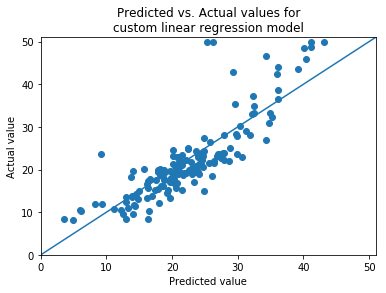

In [121]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/01_linear_custom_pred_vs_actual.png");

In [122]:
torch.mean(torch.abs(preds[:, 0] - y_test))

tensor(3.5361)

In [123]:
torch.mean(torch.pow(preds[:, 0] - y_test, 2))

tensor(25.5036)

### Tuning learning rate

In [40]:
def r2_score_2(learning_rate: float = 0.01, 
             n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=23, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = predict(X_test, y_test, weights)
    
    return r2_score(preds, y_test)

In [41]:
lrs = np.geomspace(0.01, 0.00001, 50)

In [42]:
if TEST_ALL:
    r2s = [r2_score_2(float(lr), 10000) for lr in lrs]

In [43]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.xlim(lrs[-1], lrs[0])
    plt.semilogx(lrs, r2s);

### Analyzing best model

In [44]:
train_info = train(X_train, y_train, 
                   learning_rate=0.0002,
                   batch_size=23, 
                   n_iter=10000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = predict(X_test, y_test, weights)

In [141]:
weights['W'][:, 0]

tensor([-1.0287,  0.6121,  0.1110,  0.6947, -2.1336,  2.4057,  0.6844, -2.5920,
         2.1532, -1.4286, -2.3609,  0.8890, -4.1415])

In [139]:
np.round(lr.coef_, 4)

array([-1.0068,  0.7055,  0.279 ,  0.7096, -2.212 ,  2.3732,  0.7165,
       -2.6633,  2.6296, -1.8159, -2.3293,  0.8574, -4.196 ])

In [47]:
weights['B']

tensor([[22.6193]])

In [140]:
np.round(lr.intercept_, 4)

22.6185

## Plotting loss

In [49]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.semilogy(list(range(10000)), losses); 

## Neural network linear regression

In [50]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [51]:
# def init_weights_lr(n_in) -> Dict[str, Tensor]:
    
#     weights: Dict[str, Tensor] = {}
#     W = torch.empty(n_in, 1).uniform_(-1, 1)
#     B = torch.empty(1, 1).uniform_(-1, 1)
    
#     weights['W'] = W
#     weights['B'] = B

#     return weights

In [52]:
# def init_weights_lrnn(input_size: int, 
#                       hidden_size: int) -> Dict[str, Tensor]:
    
#     weights: Dict[str, Tensor] = {}
#     weights['W1'] = torch.randn(input_size, hidden_size)
#     weights['B1'] = torch.randn(1, hidden_size)
#     weights['W2'] = torch.randn(hidden_size, 1)
#     weights['B2'] = torch.randn(1, 1)
#     return weights

In [53]:
def init_weights_lrnn(input_size: int, 
                      hidden_size: int) -> Dict[str, Tensor]:
    
    weights: Dict[str, Tensor] = {}
    weights['W1'] = torch.empty(input_size, hidden_size).uniform_(-1, 1)
    weights['B1'] = torch.empty(1, hidden_size).uniform_(-1, 1)
    weights['W2'] = torch.empty(hidden_size, 1).uniform_(-1, 1)
    weights['B2'] = torch.empty(1, 1).uniform_(-1, 1)
    return weights

In [54]:
def forward_loss_lrnn(X: Tensor,
                      y: Tensor,
                      weights: Dict[str, Tensor]) -> Tuple[Dict[str, Tensor], float]:

    M1 = torch.mm(X, weights['W1'])

    N1 = torch.add(M1, weights['B1'])

    O1 = sigmoid(N1)
    
    M2 = torch.mm(O1, weights['W2'])

    P = torch.add(M2, weights['B2'].item())    

    loss = torch.sum(torch.pow(y - P, 2)).item()

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [55]:
def loss_gradients_lrnn(forward_info: Dict[str, Tensor], 
                        weights: Dict[str, Tensor]) -> Dict[str, Tensor]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = torch.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = torch.ones_like(weights['B2'])

    dLdB2 = dLdP * dPdB2
    
    dM2dW2 = forward_info['O1'].transpose(0, 1)
    
    dLdW2 = torch.mm(dM2dW2, dLdP)

    dM2dO1 = weights['W2'].transpose(0, 1) 

    dLdO1 = torch.mm(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1'], deriv=True)
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = torch.ones_like(weights['B1'])
    
    dN1dM1 = torch.ones_like(forward_info['M1'])
    
    dLdB1 = dLdN1 * dN1dB1
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = forward_info['X'].transpose(0, 1) 

    dLdW1 = torch.mm(dM1dW1, dLdM1)
    
    def _bias_gradient(dLdB):
        batch_sum = torch.sum(dLdB, dim=0)
        size = batch_sum.shape[0]
        return batch_sum.reshape(1, size)
    
    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = torch.sum(dLdB2)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = _bias_gradient(dLdB1)
    
    return loss_gradients

In [56]:
def predict(X: Tensor, 
            y: Tensor, 
            weights: Dict[str, Tensor]):
    
    M1 = torch.mm(X, weights['W1'])

    N1 = torch.add(M1, weights['B1'])

    O1 = sigmoid(N1)
    
    M2 = torch.mm(O1, weights['W2'])

    P = torch.add(M2, weights['B2'].item())    

    return P

In [57]:
def train(X_train: Tensor, y_train: Tensor,
          X_test: Tensor, y_test: Tensor,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y_train = to_2d(y_train, "col")
    y_test = to_2d(y_test, "col")
    start = 0

    # Initialize weights
    weights = init_weights_lrnn(X_train.shape[1], 
                                hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    
    if return_losses:
        losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss_lrnn(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients_lrnn(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, y_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [59]:
num_iter = 100000
test_every = 1000
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=num_iter,
                   test_every = test_every,
                   learning_rate = 0.00001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=True,
                   seed=80718)
losses = train_info[0]
weights = train_info[1]
val_scores = train_info[2]

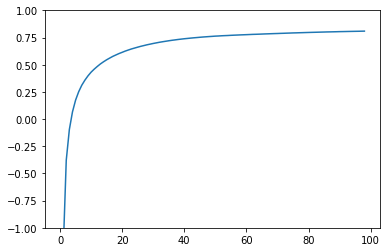

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylim([-1,1])
plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 

In [61]:
preds = predict(X_test, y_test, weights)

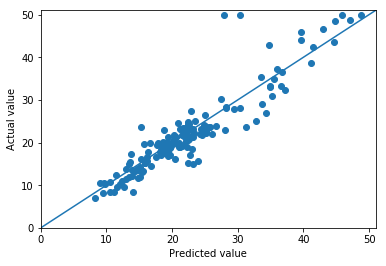

In [62]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

### Testing most important feature

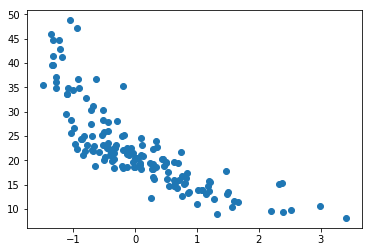

In [63]:
plt.scatter(X_test[:, 12], preds)

In [64]:
np.mean(np.array(np.abs(preds[:, 0] - y_test)))

2.384995

In [65]:
np.mean(np.array(np.power(preds[:, 0] - y_test, 2)))

13.76389

# Logistic regression

### Helpers

In [ ]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [ ]:
def softmax(x: Tensor) -> Tensor:

    assert x.dim() == 2, \
    "Expect Tensor with shape (batch_size, num_classes), instead " + \
    "x has shape {0}".format(x.shape)
    
    def _softmax_row(row: Tensor) -> Tensor:
        
        assert row.dim() == 1, \
        "'row' should indeed be a row, instead it has shape" \
        .format(row.shape)
        
        exp_obs = torch.exp(row)
        sum_exp_obs = exp_obs.sum().item()
        softmax_obs = exp_obs / sum_exp_obs
        
        return softmax_obs

    output_rows = []
    for obs in range(x.shape[0]):
        output_row = to_2d(_softmax_row(x[obs]), "row")
        output_rows.append(output_row)
        
    return torch.cat(output_rows)
    

In [ ]:
softmax(Tensor([[10, 8, 6, 4, 2]]))

## Sklearn logistic regression

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

### Data prep

In [ ]:
s = StandardScaler()
data = s.fit_transform(data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, 
                                                    random_state=80718,
                                                    stratify=target)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
logr = LogisticRegression(C=10e9)
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

### Hand rolled logistic regression

#### Data preprocessing

In [ ]:
def predictions_to_2d(predictions: Tensor) -> Tensor:
    
    assert predictions.shape[1] == 1, \
    "Expected a column for predictions, got shape: {}".format(predictions.shape)
    
    inverse_predictions = 1 - predictions
    
    return torch.cat([predictions, inverse_predictions], dim=1)

In [ ]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [ ]:
y_train, y_test = predictions_to_2d(to_2d(y_train, "col")), predictions_to_2d(to_2d(y_test, "col"))

### Modeling functions

In [ ]:
def forward_logistic(X: Tensor,
                     y: Tensor,
                     W: Tensor, 
                     B: Tensor) -> Tensor:
    
    # For the matrix multiplication to work, 
#     assert observations.shape[1] == betas.shape[0], \
#     "Dimensions of betas and feature size do not match"
    
    N = torch.mm(X, W)
    
    O = torch.add(N, B.item())
    
    P = sigmoid(O)

    P = predictions_to_2d(P)
    
    L = cross_entropy(softmax(P), y)
    
    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['W'] = W
    forward_info['B'] = B
    forward_info['N'] = N
    forward_info['O'] = O
    forward_info['P'] = P  
    forward_info['y'] = y 
    
    return forward_info, L.sum().item() / X.shape[0]

In [ ]:
def cross_entropy(predictions: Tensor, 
                  actual: Tensor) -> Tensor:
    
    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"
    
    return -1.0 * actual * torch.log(predictions) - (1.0 - actual) * torch.log(1 - predictions)

In [ ]:
def loss_bce_softmax_deriv(predictions: Tensor, 
                           actual: Tensor) -> Tensor:

    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"

    return to_2d((predictions - actual)[:, 0], "col")

In [ ]:
def loss_gradients_logistic(forward_info: Dict[str, Tensor]) -> Tensor:

#     import pdb; pdb.set_trace()
    dLdP = loss_bce_softmax_deriv(forward_info['P'], 
                                  forward_info['y'])
    
    dPdO = sigmoid(forward_info['O'], deriv=True)
    
    dLdO = dLdP * dPdO
    
    dOdB = torch.ones_like(forward_info['B'])
    
    dLdB = dLdO * dOdB
    
    dOdN = torch.ones_like(forward_info['N'])
    
    dLdN = dLdO * dOdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = dNdW.mm(dLdN)
    
    return dLdW, dLdB

In [ ]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    start = 0

    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size
    
        forward_info, loss = forward_logistic(X_batch, y_batch, W, B)

        if return_losses:
            losses.append(loss)

        dLdW, dLdB = loss_gradients_logistic(forward_info)
        W -= learning_rate * dLdW
        B -= learning_rate * torch.sum(dLdB)
    
    if return_weights:
        weights: Dict[str, Tensor] = {}
        weights['W'] = W
        weights['B'] = B
        return losses, weights
    
    return None

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=20, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

In [ ]:
def logistic_predict(X: Tensor, 
                     y: Tensor, 
                     weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])
    
    O = torch.add(N, weights['B'].item())
    
    P = sigmoid(O)

    return P >= 0.5

### Prediction

In [ ]:
preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
accuracy_score(preds, y_test[:, 0])

In [ ]:
def accuracy_score_lr(learning_rate: float = 0.01, 
                      n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=20, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = logistic_predict(X_test, y_test, weights)[:, 0]
    
    return accuracy_score(preds, y_test[:, 0])

In [ ]:
iters = np.geomspace(10, 10000, 50)

In [ ]:
accs = [accuracy_score_lr(0.01, int(it)) for it in iters]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(iters, accs);

In [ ]:
lrs = np.geomspace(0.1, 0.00001, 50)

In [ ]:
accs_lr = [accuracy_score_lr(float(lr), 1000) for lr in lrs]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(lrs, accs_lr);

### Analyzing best model

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate=0.01,
                   batch_size=20, 
                   n_iter=1000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
logr.coef_

In [ ]:
weights['W']

In [ ]:
def logistic_baseline_random(X: Tensor, 
                             y: Tensor,
                             seed: int = 1):
    
    torch.manual_seed(seed)
    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)
    
    weights: Dict[str, Tensor] = {}
    weights['W'] = W
    weights['B'] = B

    preds = logistic_predict(X, y, weights)[:, 0]
    
    return accuracy_score(preds, y[:, 0])

In [ ]:
target_2d = predictions_to_2d(to_2d(Tensor(target), "col"))

In [ ]:
logistic_baseline_random(Tensor(data), target_2d, 
                         seed=80718)

In [ ]:
a = sum(target == 1) / len(target)
a ** 2 + (1 - a) ** 2